# <Font color = 'indianred'>**Load Libraries/Install Software**

In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade -qq
    !pip install torchmetrics -qq
    !pip install transformers evaluate wandb accelerate -U -qq
    !pip install torchinfo

    basepath = '/content/drive/MyDrive/data'

else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt



# <Font color = 'indianred'>**Specify Project Folders**

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets/aclImdb'
model_folder = base_folder/'models/nlp_fall_2023/imdb/nn'
custom_functions = base_folder/'custom-functions'

In [4]:
model_folder.mkdir(exist_ok=True)

# <Font color = 'indianred'>**Data Preparation**

For this notebook, we will use IMDB movie review dataset. <br>
LInk for complete dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

We downloaded the dataset in the previous lecture 2 notebook (notebook: 3_Faster_tokenization_spacy_final.ipynb)

We created csv files in Lecture 2 -- train.csv and test.csv file. The files are availible in Lecture2/data folder from eLearning. I have applied the custom pre=processor and cleaned the data set for this lecture. I pickled the datasets and saved them as files. The files are available in data folder. We will download the following files as well.

- 'x_train_cleaned_bag_of_words.pkl'
- 'x_valid_cleaned_bag_of_words.pkl'
- 'x_test_cleaned_bag_of_words.pkl'

##  <Font color = 'indianred'>**Load cleaned arrays from indianredd files using joblib**

In [5]:
X_train_cleaned_file = data_folder / 'x_train_cleaned_bag_of_words.pkl'
X_valid_cleaned_file = data_folder / 'x_valid_cleaned_bag_of_words.pkl'
X_test_cleaned_file = data_folder / 'x_test_cleaned_bag_of_words.pkl'

In [6]:
X_train_cleaned, y_train = joblib.load(X_train_cleaned_file)
X_valid_cleaned, y_valid = joblib.load(X_valid_cleaned_file)
X_test_cleaned, y_test = joblib.load(X_test_cleaned_file)

In [7]:
type(y_train)

numpy.ndarray

In [8]:
type(X_train_cleaned)

list

## <Font color = 'indianred'>**Custom Dataset Class**

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Converting the feature data to a NumPy array for consistency
        self.X = np.array(X)

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [10]:
trainset = CustomDataset(X_train_cleaned, y_train)
validset = CustomDataset(X_valid_cleaned, y_valid)
testset = CustomDataset(X_test_cleaned, y_test)

In [11]:
trainset[1][1]

'horror movie alright let start kate main goal include get lay george clooney look good screw got to love 3 amazingly good chance finish sicko instead run mean wanna bring guy 10 minute late mean guy try rape not movie main character sad idiot mean honestly sympathy guy finish meet night movie keep go result lose credibility'

In [12]:
trainset[1][0]

0

## <Font color = 'indianred'>**Create Vocab**

In [13]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (l_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab


vocab should always be created based on trainset

In [14]:
imdb_vocab = get_vocab(trainset, min_freq=2)

In [15]:
len(imdb_vocab)

36153

In [16]:
imdb_vocab.get_itos()[0:5]

['<unk>', 'george', 'brent', 'reporter', 'send']

In [17]:
imdb_vocab['abracadabra']

0

## <Font color = 'indianred'>**Collate_fn for Data Loaders**

In [18]:

# Creating a function that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [19]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [text_pipeline(text, my_vocab) for text in texts]

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return {
        'input_ids': texts,
        'offsets': offsets,
        'labels': labels
    }


# <Font color = 'indianred'>**Model**
embedding_layer-->linear--> ReLU -->dropout --> batch norm --> linear-->ReLu-->Dropout--> batchnorm ---> linear layer

In [20]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
import torch
import torch.nn as nn

In [21]:
class CustomConfig(PretrainedConfig):
  def __init__(self, vocab_size=0, embedding_dim=0, hidden_dim1=0, hidden_dim2=0, num_labels=0, **kwargs):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.hidden_dim1 = hidden_dim1
      self.hidden_dim2 = hidden_dim2
      self.num_labels = num_labels

In [22]:
class CustomMLP(PreTrainedModel):
    # config_class = CustomConfig

    def __init__(self, config):
        super().__init__(config)

        self.embedding_bag = nn.EmbeddingBag(config.vocab_size, config.embedding_dim)
        self.layers = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim1),
            nn.BatchNorm1d(num_features=config.hidden_dim1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim1, config.hidden_dim2),
            nn.BatchNorm1d(num_features=config.hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(config.hidden_dim2, config.num_labels)
        )

    def forward(self, input_ids, offsets, labels=None):
        embed_out = self.embedding_bag(input_ids, offsets)
        logits = self.layers(embed_out)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )


# <Font color = 'indianred'>**Hyperparameters**

In [23]:
hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(imdb_vocab),
    OUTPUT_DIM=2,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    DROP_PROB1=0.5,
    DROP_PROB2=0.5,
    NUM_OUTPUTS=2,

    # training
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.1,
)

collate_fn = partial(collate_batch, my_vocab=imdb_vocab)

# <Font color = 'indianred'>**Training Configuration**

In [24]:
import wandb

In [25]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
%env WANDB_PROJECT = nlp_course_fall_2023-sentiment-analysis-trainer

env: WANDB_PROJECT=nlp_course_fall_2023-sentiment-analysis-trainer


In [28]:
my_config = CustomConfig(vocab_size=len(imdb_vocab),
                         embedding_dim=hyperparameters.EMBED_DIM,
                         hidden_dim1=hyperparameters.HIDDEN_DIM1,
                         hidden_dim2=hyperparameters.HIDDEN_DIM2,
                         num_labels=hyperparameters.NUM_OUTPUTS)



In [29]:
my_config

CustomConfig {
  "embedding_dim": 300,
  "hidden_dim1": 200,
  "hidden_dim2": 100,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "transformers_version": "4.33.2",
  "vocab_size": 36153
}

In [30]:
model = CustomMLP(config=my_config)

In [31]:
import evaluate
def compute_metrics(eval_pred):
    combined_metrics = evaluate.combine([evaluate.load("accuracy", average="macro"),
                                        evaluate.load("f1", average="macro")])

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    evaluations = combined_metrics.compute(
        predictions=predictions, references=labels, average='macro')
    return evaluations


In [32]:
from transformers import TrainingArguments, Trainer
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/imdb/hf-trainer"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=hyperparameters.EPOCHS,
    # Number of samples per training batch for each device
    per_device_train_batch_size=hyperparameters.BATCH_SIZE,
    per_device_eval_batch_size=hyperparameters.BATCH_SIZE,
    weight_decay=hyperparameters.WEIGHT_DECAY,
    learning_rate=hyperparameters.LEARNING_RATE,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='imdb_hf_trainer',  # Experiment name for Weights & Biases
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset = validset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)


In [34]:
trainer.train()

wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230918_205245-1e6qqcj6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run imdb_hf_trainer
wandb: ⭐️ View project at https://wandb.ai/hsingh-utd/nlp_course_fall_2023-sentiment-analysis-trainer
wandb: 🚀 View run at https://wandb.ai/hsingh-utd/nlp_course_fall_2023-sentiment-analysis-trainer/runs/1e6qqcj6


Step,Training Loss,Validation Loss,Accuracy,F1
20,0.698700,0.673846,0.629800,0.697796
40,0.620900,0.598764,0.719600,0.724990
60,0.565900,0.523710,0.752000,0.757623
80,0.549000,0.494320,0.770400,0.779146
100,0.515800,0.473592,0.781200,0.793507
120,0.475800,0.449112,0.795600,0.796333
140,0.475800,0.431778,0.805400,0.811178
160,0.452700,0.424203,0.808200,0.817785
180,0.388300,0.408617,0.817400,0.820945
200,0.387500,0.398907,0.824200,0.829354


TrainOutput(global_step=785, training_loss=0.32500111980802693, metrics={'train_runtime': 106.0047, 'train_samples_per_second': 943.355, 'train_steps_per_second': 7.405, 'total_flos': 690481408640760.0, 'train_loss': 0.32500111980802693, 'epoch': 5.0})

In [35]:
trainer.evaluate(trainset)

{'eval_loss': 0.16375374794006348,
 'eval_accuracy': 0.9434,
 'eval_f1': 0.9432695198957602,
 'eval_runtime': 3.993,
 'eval_samples_per_second': 5008.813,
 'eval_steps_per_second': 39.319,
 'epoch': 5.0}

In [36]:
trainer.evaluate(validset)

{'eval_loss': 0.34776434302330017,
 'eval_accuracy': 0.8608,
 'eval_f1': 0.8614649681528662,
 'eval_runtime': 1.9906,
 'eval_samples_per_second': 2511.782,
 'eval_steps_per_second': 20.094,
 'epoch': 5.0}

In [37]:
trainer.evaluate(testset)

{'eval_loss': 0.3803828954696655,
 'eval_accuracy': 0.84,
 'eval_f1': 0.8374644453474197,
 'eval_runtime': 4.8561,
 'eval_samples_per_second': 5148.209,
 'eval_steps_per_second': 40.362,
 'epoch': 5.0}

In [38]:
test_output = trainer.predict(testset)

In [39]:
test_output._fields

('predictions', 'label_ids', 'metrics')

In [40]:
import numpy as np
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = np.array(test_output.label_ids)

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

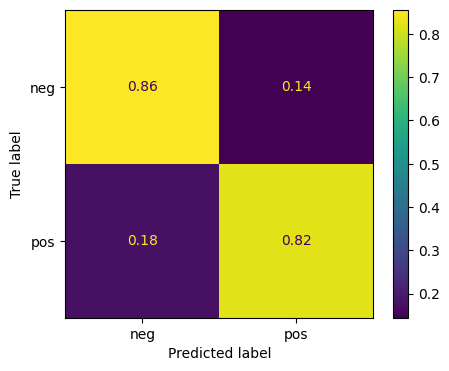

In [42]:
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_true=test_labels,
    y_pred=test_preds,
    ax=ax,
    normalize="true",
    display_labels=['neg', 'pos'],
)


In [43]:
# log the Confusion Matrix to Wandb
wandb.log({"conf_mat": wandb.plot.confusion_matrix(
    preds=test_preds, y_true=test_labels,
    class_names=['neg', 'pos'])})


In [44]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                  eval/accuracy ▁▃▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▆
wandb:                        eval/f1 ▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█▅
wandb:                      eval/loss █▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▁▄
wandb:                   eval/runtime ▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▆█
wandb:        eval/samples_per_second ▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
wandb:          eval/steps_per_second ▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂██
wandb:                    train/epoch ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
wandb:              train/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
wandb:            train/learning_rate ███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
wandb:                     train/loss █▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁
wandb:               train/total_flos ▁
wandb:               train/train_loss ▁
wandb:            train/train_runtime ▁
wandb: tr